<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:00:23] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


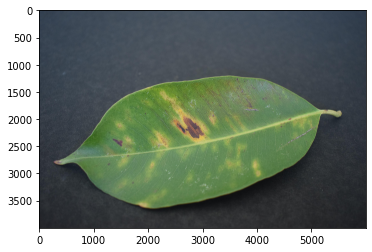

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

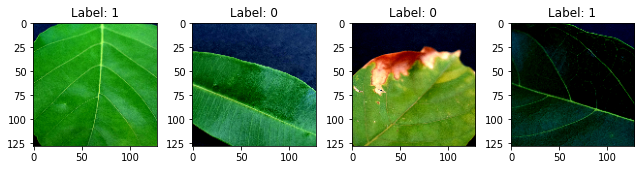

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:00:29] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:00:31] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2838539518424372 samples/sec                   batch loss = 1.001428246498108 | accuracy = 0.55


Epoch[1] Batch[10] Speed: 1.2968340481146523 samples/sec                   batch loss = 0.942094624042511 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2990571058987754 samples/sec                   batch loss = 0.6291840672492981 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.294361695102088 samples/sec                   batch loss = 0.6088287234306335 | accuracy = 0.6375


Epoch[1] Batch[25] Speed: 1.2978970810340122 samples/sec                   batch loss = 0.5178301334381104 | accuracy = 0.62


Epoch[1] Batch[30] Speed: 1.2970714641844114 samples/sec                   batch loss = 1.0189571380615234 | accuracy = 0.6083333333333333


Epoch[1] Batch[35] Speed: 1.3000100500168494 samples/sec                   batch loss = 0.7125398516654968 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2582351770787406 samples/sec                   batch loss = 0.665148138999939 | accuracy = 0.5875


Epoch[1] Batch[45] Speed: 1.295951218419465 samples/sec                   batch loss = 0.44815918803215027 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.3031977997625115 samples/sec                   batch loss = 1.0223151445388794 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2957210169467963 samples/sec                   batch loss = 0.8086298704147339 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2955838357513985 samples/sec                   batch loss = 0.5069552659988403 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.296443022499337 samples/sec                   batch loss = 0.4805014431476593 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.2990307529589211 samples/sec                   batch loss = 0.9996965527534485 | accuracy = 0.6071428571428571


Epoch[1] Batch[75] Speed: 1.2995008407105282 samples/sec                   batch loss = 0.4126726984977722 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.3016715522363371 samples/sec                   batch loss = 0.345226913690567 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.3018594227196492 samples/sec                   batch loss = 1.045802116394043 | accuracy = 0.6176470588235294


Epoch[1] Batch[90] Speed: 1.3024784657518251 samples/sec                   batch loss = 0.6007444858551025 | accuracy = 0.6222222222222222


Epoch[1] Batch[95] Speed: 1.3008529289051196 samples/sec                   batch loss = 0.5917880535125732 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.3034011986133487 samples/sec                   batch loss = 0.5178679823875427 | accuracy = 0.6325


Epoch[1] Batch[105] Speed: 1.3023067928897774 samples/sec                   batch loss = 0.4156999886035919 | accuracy = 0.6404761904761904


Epoch[1] Batch[110] Speed: 1.3017276046883315 samples/sec                   batch loss = 0.7226933836936951 | accuracy = 0.6409090909090909


Epoch[1] Batch[115] Speed: 1.3009893114290405 samples/sec                   batch loss = 0.41486412286758423 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.29792770565356 samples/sec                   batch loss = 0.8025704026222229 | accuracy = 0.65


Epoch[1] Batch[125] Speed: 1.3016186350721697 samples/sec                   batch loss = 0.5496587157249451 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.3034641851468685 samples/sec                   batch loss = 1.0155646800994873 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.301211498630903 samples/sec                   batch loss = 0.7472679615020752 | accuracy = 0.6555555555555556


Epoch[1] Batch[140] Speed: 1.2989406380080142 samples/sec                   batch loss = 0.8240604996681213 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.3037820460713978 samples/sec                   batch loss = 0.20851962268352509 | accuracy = 0.6551724137931034


Epoch[1] Batch[150] Speed: 1.2970289474858085 samples/sec                   batch loss = 0.7490429878234863 | accuracy = 0.65


Epoch[1] Batch[155] Speed: 1.299650732561475 samples/sec                   batch loss = 0.4000759720802307 | accuracy = 0.65


Epoch[1] Batch[160] Speed: 1.298015169491427 samples/sec                   batch loss = 0.849151611328125 | accuracy = 0.65


Epoch[1] Batch[165] Speed: 1.3000813731819378 samples/sec                   batch loss = 0.7576202750205994 | accuracy = 0.6515151515151515


Epoch[1] Batch[170] Speed: 1.3058884169025258 samples/sec                   batch loss = 0.6231270432472229 | accuracy = 0.6470588235294118


Epoch[1] Batch[175] Speed: 1.3001032350975155 samples/sec                   batch loss = 0.3504789471626282 | accuracy = 0.6457142857142857


Epoch[1] Batch[180] Speed: 1.299635530402032 samples/sec                   batch loss = 1.0244109630584717 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.3020923159691957 samples/sec                   batch loss = 0.3420259952545166 | accuracy = 0.65


Epoch[1] Batch[190] Speed: 1.306022400677563 samples/sec                   batch loss = 0.2993645966053009 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.3026223701567676 samples/sec                   batch loss = 0.6452003121376038 | accuracy = 0.6487179487179487


Epoch[1] Batch[200] Speed: 1.303732503054139 samples/sec                   batch loss = 0.5723042488098145 | accuracy = 0.65


Epoch[1] Batch[205] Speed: 1.2952295604065842 samples/sec                   batch loss = 0.6816567182540894 | accuracy = 0.6536585365853659


Epoch[1] Batch[210] Speed: 1.3017671977977086 samples/sec                   batch loss = 0.33118167519569397 | accuracy = 0.6547619047619048


Epoch[1] Batch[215] Speed: 1.300707196647309 samples/sec                   batch loss = 0.7512246370315552 | accuracy = 0.6523255813953488


Epoch[1] Batch[220] Speed: 1.2973062586933168 samples/sec                   batch loss = 0.421027809381485 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.2940186671956724 samples/sec                   batch loss = 0.4113161563873291 | accuracy = 0.6566666666666666


Epoch[1] Batch[230] Speed: 1.2994596743205769 samples/sec                   batch loss = 0.4892319440841675 | accuracy = 0.6532608695652173


Epoch[1] Batch[235] Speed: 1.3012795220548798 samples/sec                   batch loss = 0.46100014448165894 | accuracy = 0.652127659574468


Epoch[1] Batch[240] Speed: 1.3062392930749187 samples/sec                   batch loss = 0.37031975388526917 | accuracy = 0.6510416666666666


Epoch[1] Batch[245] Speed: 1.301233802263716 samples/sec                   batch loss = 0.5081996917724609 | accuracy = 0.6530612244897959


Epoch[1] Batch[250] Speed: 1.3030544766377852 samples/sec                   batch loss = 0.5836477875709534 | accuracy = 0.652


Epoch[1] Batch[255] Speed: 1.2990864776107338 samples/sec                   batch loss = 0.5352864265441895 | accuracy = 0.6558823529411765


Epoch[1] Batch[260] Speed: 1.2994147868044605 samples/sec                   batch loss = 0.8684237003326416 | accuracy = 0.6528846153846154


Epoch[1] Batch[265] Speed: 1.3005949697693278 samples/sec                   batch loss = 0.6083905100822449 | accuracy = 0.6518867924528302


Epoch[1] Batch[270] Speed: 1.3047419374682265 samples/sec                   batch loss = 0.34703490138053894 | accuracy = 0.6527777777777778


Epoch[1] Batch[275] Speed: 1.3001328556399172 samples/sec                   batch loss = 0.7011187672615051 | accuracy = 0.6536363636363637


Epoch[1] Batch[280] Speed: 1.2981780784596442 samples/sec                   batch loss = 0.5125971436500549 | accuracy = 0.6553571428571429


Epoch[1] Batch[285] Speed: 1.2988080026971383 samples/sec                   batch loss = 0.5856817960739136 | accuracy = 0.6543859649122807


Epoch[1] Batch[290] Speed: 1.2948877714062021 samples/sec                   batch loss = 0.8427415490150452 | accuracy = 0.6543103448275862


Epoch[1] Batch[295] Speed: 1.2972235042398335 samples/sec                   batch loss = 0.22159980237483978 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2999954438369217 samples/sec                   batch loss = 0.6291924118995667 | accuracy = 0.6583333333333333


Epoch[1] Batch[305] Speed: 1.2984434203424466 samples/sec                   batch loss = 0.5161207914352417 | accuracy = 0.6598360655737705


Epoch[1] Batch[310] Speed: 1.30545016286209 samples/sec                   batch loss = 0.7832571268081665 | accuracy = 0.660483870967742


Epoch[1] Batch[315] Speed: 1.3014397180604493 samples/sec                   batch loss = 1.2745672464370728 | accuracy = 0.6587301587301587


Epoch[1] Batch[320] Speed: 1.3010740605372808 samples/sec                   batch loss = 0.43457865715026855 | accuracy = 0.6609375


Epoch[1] Batch[325] Speed: 1.2995662694353416 samples/sec                   batch loss = 0.5526289343833923 | accuracy = 0.66


Epoch[1] Batch[330] Speed: 1.2949217522905316 samples/sec                   batch loss = 0.6730496883392334 | accuracy = 0.6621212121212121


Epoch[1] Batch[335] Speed: 1.2985257274982445 samples/sec                   batch loss = 0.3890489935874939 | accuracy = 0.6619402985074627


Epoch[1] Batch[340] Speed: 1.2986894683577306 samples/sec                   batch loss = 0.30332714319229126 | accuracy = 0.663235294117647


Epoch[1] Batch[345] Speed: 1.299316367187019 samples/sec                   batch loss = 0.5184101462364197 | accuracy = 0.6644927536231884


Epoch[1] Batch[350] Speed: 1.290171796655486 samples/sec                   batch loss = 0.6218442916870117 | accuracy = 0.6628571428571428


Epoch[1] Batch[355] Speed: 1.2917487521353386 samples/sec                   batch loss = 0.8426460027694702 | accuracy = 0.6633802816901408


Epoch[1] Batch[360] Speed: 1.2974268483241933 samples/sec                   batch loss = 0.6163640022277832 | accuracy = 0.6631944444444444


Epoch[1] Batch[365] Speed: 1.3007894884971125 samples/sec                   batch loss = 1.5116912126541138 | accuracy = 0.665068493150685


Epoch[1] Batch[370] Speed: 1.3036496358305474 samples/sec                   batch loss = 0.25339439511299133 | accuracy = 0.6668918918918919


Epoch[1] Batch[375] Speed: 1.3020435075763879 samples/sec                   batch loss = 0.6104636192321777 | accuracy = 0.6686666666666666


Epoch[1] Batch[380] Speed: 1.3074197864608945 samples/sec                   batch loss = 0.4106859564781189 | accuracy = 0.6703947368421053


Epoch[1] Batch[385] Speed: 1.3029570227757092 samples/sec                   batch loss = 0.5790274143218994 | accuracy = 0.6707792207792208


Epoch[1] Batch[390] Speed: 1.30060122089199 samples/sec                   batch loss = 1.0725622177124023 | accuracy = 0.6711538461538461


Epoch[1] Batch[395] Speed: 1.3065175047885038 samples/sec                   batch loss = 0.8590890765190125 | accuracy = 0.6721518987341772


Epoch[1] Batch[400] Speed: 1.2980176801085626 samples/sec                   batch loss = 0.45687901973724365 | accuracy = 0.67375


Epoch[1] Batch[405] Speed: 1.2971469783057532 samples/sec                   batch loss = 0.48748669028282166 | accuracy = 0.6734567901234568


Epoch[1] Batch[410] Speed: 1.3018238645754365 samples/sec                   batch loss = 0.46257877349853516 | accuracy = 0.6743902439024391


Epoch[1] Batch[415] Speed: 1.3023235739887948 samples/sec                   batch loss = 0.6916584968566895 | accuracy = 0.6765060240963855


Epoch[1] Batch[420] Speed: 1.2986958017065588 samples/sec                   batch loss = 0.21637549996376038 | accuracy = 0.675


Epoch[1] Batch[425] Speed: 1.2976759238232194 samples/sec                   batch loss = 0.20822574198246002 | accuracy = 0.6770588235294117


Epoch[1] Batch[430] Speed: 1.3030293780916649 samples/sec                   batch loss = 1.0056346654891968 | accuracy = 0.6744186046511628


Epoch[1] Batch[435] Speed: 1.3031297780777666 samples/sec                   batch loss = 0.3487602770328522 | accuracy = 0.6764367816091954


Epoch[1] Batch[440] Speed: 1.3000202241705958 samples/sec                   batch loss = 0.6078938841819763 | accuracy = 0.675


Epoch[1] Batch[445] Speed: 1.3007859586084491 samples/sec                   batch loss = 1.6008622646331787 | accuracy = 0.6752808988764045


Epoch[1] Batch[450] Speed: 1.2969239712557667 samples/sec                   batch loss = 0.7745808362960815 | accuracy = 0.675


Epoch[1] Batch[455] Speed: 1.302144261011018 samples/sec                   batch loss = 0.5505560040473938 | accuracy = 0.6747252747252748


Epoch[1] Batch[460] Speed: 1.300001487733636 samples/sec                   batch loss = 0.45907163619995117 | accuracy = 0.675


Epoch[1] Batch[465] Speed: 1.299641872981609 samples/sec                   batch loss = 0.4542819857597351 | accuracy = 0.6747311827956989


Epoch[1] Batch[470] Speed: 1.3034188180271449 samples/sec                   batch loss = 0.37626442313194275 | accuracy = 0.676063829787234


Epoch[1] Batch[475] Speed: 1.306350868696181 samples/sec                   batch loss = 0.4016400873661041 | accuracy = 0.6789473684210526


Epoch[1] Batch[480] Speed: 1.3060276873993655 samples/sec                   batch loss = 0.5011090040206909 | accuracy = 0.6791666666666667


Epoch[1] Batch[485] Speed: 1.293322987088213 samples/sec                   batch loss = 0.4754053056240082 | accuracy = 0.6809278350515464


Epoch[1] Batch[490] Speed: 1.2979046115441701 samples/sec                   batch loss = 0.14835910499095917 | accuracy = 0.6811224489795918


Epoch[1] Batch[495] Speed: 1.299949512058374 samples/sec                   batch loss = 0.747042715549469 | accuracy = 0.6813131313131313


Epoch[1] Batch[500] Speed: 1.2997496056139288 samples/sec                   batch loss = 1.1958541870117188 | accuracy = 0.6805


Epoch[1] Batch[505] Speed: 1.3012606483742246 samples/sec                   batch loss = 0.42500630021095276 | accuracy = 0.6811881188118812


Epoch[1] Batch[510] Speed: 1.29579267089885 samples/sec                   batch loss = 0.3253090977668762 | accuracy = 0.6823529411764706


Epoch[1] Batch[515] Speed: 1.294819215403836 samples/sec                   batch loss = 0.3230708837509155 | accuracy = 0.683009708737864


Epoch[1] Batch[520] Speed: 1.3006013217170413 samples/sec                   batch loss = 1.2781192064285278 | accuracy = 0.68125


Epoch[1] Batch[525] Speed: 1.300620781244634 samples/sec                   batch loss = 0.6119261384010315 | accuracy = 0.68


Epoch[1] Batch[530] Speed: 1.3039069841401347 samples/sec                   batch loss = 0.6925324201583862 | accuracy = 0.6806603773584906


Epoch[1] Batch[535] Speed: 1.3054098375452106 samples/sec                   batch loss = 0.5407403111457825 | accuracy = 0.6822429906542056


Epoch[1] Batch[540] Speed: 1.2975684343105254 samples/sec                   batch loss = 0.6936286091804504 | accuracy = 0.6828703703703703


Epoch[1] Batch[545] Speed: 1.2939586859435261 samples/sec                   batch loss = 0.21379487216472626 | accuracy = 0.6853211009174311


Epoch[1] Batch[550] Speed: 1.2954253781042186 samples/sec                   batch loss = 0.6420487761497498 | accuracy = 0.685


Epoch[1] Batch[555] Speed: 1.2939572887759732 samples/sec                   batch loss = 0.4710637927055359 | accuracy = 0.6842342342342342


Epoch[1] Batch[560] Speed: 1.297851197013859 samples/sec                   batch loss = 0.870817244052887 | accuracy = 0.684375


Epoch[1] Batch[565] Speed: 1.2981347860824906 samples/sec                   batch loss = 0.5451640486717224 | accuracy = 0.6849557522123894


Epoch[1] Batch[570] Speed: 1.2948411005691223 samples/sec                   batch loss = 0.8153223395347595 | accuracy = 0.6859649122807018


Epoch[1] Batch[575] Speed: 1.2956093486544356 samples/sec                   batch loss = 0.38443708419799805 | accuracy = 0.6869565217391305


Epoch[1] Batch[580] Speed: 1.2961429485810172 samples/sec                   batch loss = 0.3082652986049652 | accuracy = 0.6875


Epoch[1] Batch[585] Speed: 1.3006134208367108 samples/sec                   batch loss = 0.3149917423725128 | accuracy = 0.6888888888888889


Epoch[1] Batch[590] Speed: 1.2979535117828167 samples/sec                   batch loss = 0.8214685320854187 | accuracy = 0.6885593220338984


Epoch[1] Batch[595] Speed: 1.3135933829006121 samples/sec                   batch loss = 2.0233428478240967 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.3061580389617327 samples/sec                   batch loss = 1.2675540447235107 | accuracy = 0.6883333333333334


Epoch[1] Batch[605] Speed: 1.3048529529685782 samples/sec                   batch loss = 0.2642641067504883 | accuracy = 0.6884297520661157


Epoch[1] Batch[610] Speed: 1.299400395275346 samples/sec                   batch loss = 0.6032732725143433 | accuracy = 0.6881147540983606


Epoch[1] Batch[615] Speed: 1.2983803152074231 samples/sec                   batch loss = 0.3715059459209442 | accuracy = 0.6878048780487804


Epoch[1] Batch[620] Speed: 1.2960401180936365 samples/sec                   batch loss = 0.6431265473365784 | accuracy = 0.6887096774193548


Epoch[1] Batch[625] Speed: 1.2922075121293568 samples/sec                   batch loss = 0.43385642766952515 | accuracy = 0.6892


Epoch[1] Batch[630] Speed: 1.3033382181668574 samples/sec                   batch loss = 0.7438005805015564 | accuracy = 0.6888888888888889


Epoch[1] Batch[635] Speed: 1.300438207230613 samples/sec                   batch loss = 0.3210976719856262 | accuracy = 0.6905511811023622


Epoch[1] Batch[640] Speed: 1.2981844068216286 samples/sec                   batch loss = 0.5302470326423645 | accuracy = 0.690234375


Epoch[1] Batch[645] Speed: 1.3013504798808702 samples/sec                   batch loss = 0.7443708181381226 | accuracy = 0.6895348837209302


Epoch[1] Batch[650] Speed: 1.3008358831001132 samples/sec                   batch loss = 0.5431475639343262 | accuracy = 0.6896153846153846


Epoch[1] Batch[655] Speed: 1.3011276397769382 samples/sec                   batch loss = 0.5452504754066467 | accuracy = 0.6912213740458015


Epoch[1] Batch[660] Speed: 1.2963808128528356 samples/sec                   batch loss = 0.4447043836116791 | accuracy = 0.6912878787878788


Epoch[1] Batch[665] Speed: 1.2967719011689656 samples/sec                   batch loss = 0.9206879138946533 | accuracy = 0.6909774436090226


Epoch[1] Batch[670] Speed: 1.292068586186958 samples/sec                   batch loss = 0.32593339681625366 | accuracy = 0.6914179104477612


Epoch[1] Batch[675] Speed: 1.2924235236695265 samples/sec                   batch loss = 0.9187992215156555 | accuracy = 0.6914814814814815


Epoch[1] Batch[680] Speed: 1.2960369142899344 samples/sec                   batch loss = 0.7475813627243042 | accuracy = 0.6911764705882353


Epoch[1] Batch[685] Speed: 1.2944077321831817 samples/sec                   batch loss = 1.5825837850570679 | accuracy = 0.6912408759124088


Epoch[1] Batch[690] Speed: 1.2979310192236295 samples/sec                   batch loss = 0.566917896270752 | accuracy = 0.6916666666666667


Epoch[1] Batch[695] Speed: 1.2948340052975063 samples/sec                   batch loss = 0.5764551758766174 | accuracy = 0.6913669064748201


Epoch[1] Batch[700] Speed: 1.2965180626898636 samples/sec                   batch loss = 0.42437636852264404 | accuracy = 0.6910714285714286


Epoch[1] Batch[705] Speed: 1.3027174474303556 samples/sec                   batch loss = 0.21256023645401 | accuracy = 0.6921985815602837


Epoch[1] Batch[710] Speed: 1.2982185609513388 samples/sec                   batch loss = 0.463182657957077 | accuracy = 0.6926056338028169


Epoch[1] Batch[715] Speed: 1.3039424534864914 samples/sec                   batch loss = 0.5172005295753479 | accuracy = 0.6933566433566434


Epoch[1] Batch[720] Speed: 1.2935937285915384 samples/sec                   batch loss = 0.4717406630516052 | accuracy = 0.6947916666666667


Epoch[1] Batch[725] Speed: 1.3039050587165517 samples/sec                   batch loss = 0.4290594160556793 | accuracy = 0.6948275862068966


Epoch[1] Batch[730] Speed: 1.2988435973842616 samples/sec                   batch loss = 0.2541745901107788 | accuracy = 0.6958904109589041


Epoch[1] Batch[735] Speed: 1.296034211092881 samples/sec                   batch loss = 0.575276792049408 | accuracy = 0.6962585034013605


Epoch[1] Batch[740] Speed: 1.3026421936345665 samples/sec                   batch loss = 0.597555935382843 | accuracy = 0.6966216216216217


Epoch[1] Batch[745] Speed: 1.3030867620765236 samples/sec                   batch loss = 0.829820454120636 | accuracy = 0.6966442953020134


Epoch[1] Batch[750] Speed: 1.313963436620583 samples/sec                   batch loss = 0.8382397890090942 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.3003737993670825 samples/sec                   batch loss = 0.9469427466392517 | accuracy = 0.6956953642384106


Epoch[1] Batch[760] Speed: 1.3081786585528457 samples/sec                   batch loss = 0.3509369194507599 | accuracy = 0.6960526315789474


Epoch[1] Batch[765] Speed: 1.3049403376856192 samples/sec                   batch loss = 0.3644004464149475 | accuracy = 0.6954248366013072


Epoch[1] Batch[770] Speed: 1.298906244749899 samples/sec                   batch loss = 0.9698866009712219 | accuracy = 0.6941558441558442


Epoch[1] Batch[775] Speed: 1.3014612218497763 samples/sec                   batch loss = 0.4510597586631775 | accuracy = 0.6941935483870968


Epoch[1] Batch[780] Speed: 1.302060787147971 samples/sec                   batch loss = 0.8813596963882446 | accuracy = 0.6935897435897436


Epoch[1] Batch[785] Speed: 1.3058945157184023 samples/sec                   batch loss = 0.7796863317489624 | accuracy = 0.6942675159235668


[Epoch 1] training: accuracy=0.6941624365482234
[Epoch 1] time cost: 637.6119232177734
[Epoch 1] validation: validation accuracy=0.7555555555555555


Epoch[2] Batch[5] Speed: 1.2984783920714973 samples/sec                   batch loss = 0.33912399411201477 | accuracy = 0.9


Epoch[2] Batch[10] Speed: 1.291311984409323 samples/sec                   batch loss = 0.470239520072937 | accuracy = 0.825


Epoch[2] Batch[15] Speed: 1.3012504547957988 samples/sec                   batch loss = 0.43537136912345886 | accuracy = 0.8166666666666667


Epoch[2] Batch[20] Speed: 1.2965944142284895 samples/sec                   batch loss = 0.2132519781589508 | accuracy = 0.825


Epoch[2] Batch[25] Speed: 1.3044168133795973 samples/sec                   batch loss = 0.8809404373168945 | accuracy = 0.83


Epoch[2] Batch[30] Speed: 1.3001308405942475 samples/sec                   batch loss = 0.18244032561779022 | accuracy = 0.85


Epoch[2] Batch[35] Speed: 1.2975436470058503 samples/sec                   batch loss = 0.1517052799463272 | accuracy = 0.8214285714285714


Epoch[2] Batch[40] Speed: 1.3000399685273032 samples/sec                   batch loss = 0.3946557641029358 | accuracy = 0.80625


Epoch[2] Batch[45] Speed: 1.2979574279777129 samples/sec                   batch loss = 0.8505532741546631 | accuracy = 0.7888888888888889


Epoch[2] Batch[50] Speed: 1.3023212488709532 samples/sec                   batch loss = 0.8518315553665161 | accuracy = 0.78


Epoch[2] Batch[55] Speed: 1.3003615031294076 samples/sec                   batch loss = 0.2821999788284302 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2993585308213602 samples/sec                   batch loss = 0.30096179246902466 | accuracy = 0.7666666666666667


Epoch[2] Batch[65] Speed: 1.2946412635140958 samples/sec                   batch loss = 0.4888095259666443 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2940788536415428 samples/sec                   batch loss = 0.43593350052833557 | accuracy = 0.7642857142857142


Epoch[2] Batch[75] Speed: 1.2971501875999698 samples/sec                   batch loss = 0.34167852997779846 | accuracy = 0.77


Epoch[2] Batch[80] Speed: 1.30284764489072 samples/sec                   batch loss = 0.5530250668525696 | accuracy = 0.76875


Epoch[2] Batch[85] Speed: 1.3030830172884431 samples/sec                   batch loss = 0.6302290558815002 | accuracy = 0.7705882352941177


Epoch[2] Batch[90] Speed: 1.296646021739196 samples/sec                   batch loss = 0.38376709818840027 | accuracy = 0.7583333333333333


Epoch[2] Batch[95] Speed: 1.297507120072425 samples/sec                   batch loss = 0.4747896194458008 | accuracy = 0.7578947368421053


Epoch[2] Batch[100] Speed: 1.3012575196351468 samples/sec                   batch loss = 0.5481635928153992 | accuracy = 0.7625


Epoch[2] Batch[105] Speed: 1.2960706551426506 samples/sec                   batch loss = 0.33653536438941956 | accuracy = 0.7619047619047619


Epoch[2] Batch[110] Speed: 1.3037662405280586 samples/sec                   batch loss = 1.3179951906204224 | accuracy = 0.7568181818181818


Epoch[2] Batch[115] Speed: 1.2987185218471338 samples/sec                   batch loss = 0.46324580907821655 | accuracy = 0.758695652173913


Epoch[2] Batch[120] Speed: 1.2988027742633665 samples/sec                   batch loss = 0.3588903546333313 | accuracy = 0.75625


Epoch[2] Batch[125] Speed: 1.2967936519224021 samples/sec                   batch loss = 0.309781551361084 | accuracy = 0.76


Epoch[2] Batch[130] Speed: 1.2962507027995858 samples/sec                   batch loss = 0.3680553436279297 | accuracy = 0.7596153846153846


Epoch[2] Batch[135] Speed: 1.3000815746708902 samples/sec                   batch loss = 0.30508479475975037 | accuracy = 0.7611111111111111


Epoch[2] Batch[140] Speed: 1.2997252383528433 samples/sec                   batch loss = 0.5559825897216797 | accuracy = 0.7571428571428571


Epoch[2] Batch[145] Speed: 1.3021881244486806 samples/sec                   batch loss = 0.4514831304550171 | accuracy = 0.7603448275862069


Epoch[2] Batch[150] Speed: 1.2967330122394656 samples/sec                   batch loss = 0.9658658504486084 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.2951022806537045 samples/sec                   batch loss = 0.3596170246601105 | accuracy = 0.7564516129032258


Epoch[2] Batch[160] Speed: 1.3015552209326051 samples/sec                   batch loss = 0.7768839597702026 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2906897057877729 samples/sec                   batch loss = 0.5675090551376343 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2983578078535667 samples/sec                   batch loss = 0.4739682376384735 | accuracy = 0.7470588235294118


Epoch[2] Batch[175] Speed: 1.2949151558617216 samples/sec                   batch loss = 0.3020228147506714 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2964085610235692 samples/sec                   batch loss = 0.6537306308746338 | accuracy = 0.7513888888888889


Epoch[2] Batch[185] Speed: 1.293954095261468 samples/sec                   batch loss = 0.4097440838813782 | accuracy = 0.7527027027027027


Epoch[2] Batch[190] Speed: 1.2975489656594401 samples/sec                   batch loss = 1.2270654439926147 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.3022120787716007 samples/sec                   batch loss = 0.44148528575897217 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.3019022566998177 samples/sec                   batch loss = 0.5465797781944275 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.2997675292238628 samples/sec                   batch loss = 0.36151742935180664 | accuracy = 0.748780487804878


Epoch[2] Batch[210] Speed: 1.2962776441536907 samples/sec                   batch loss = 0.14809824526309967 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2959998714599736 samples/sec                   batch loss = 0.35459625720977783 | accuracy = 0.7465116279069768


Epoch[2] Batch[220] Speed: 1.289958917447998 samples/sec                   batch loss = 0.7142059803009033 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.2920989363675843 samples/sec                   batch loss = 0.27025842666625977 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2908780943416072 samples/sec                   batch loss = 0.3686577081680298 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2927121162481272 samples/sec                   batch loss = 0.5505186915397644 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2967047490687953 samples/sec                   batch loss = 0.35407736897468567 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.292033361863412 samples/sec                   batch loss = 0.44186848402023315 | accuracy = 0.746938775510204


Epoch[2] Batch[250] Speed: 1.2937898501152536 samples/sec                   batch loss = 0.1165909394621849 | accuracy = 0.749


Epoch[2] Batch[255] Speed: 1.3026299555999672 samples/sec                   batch loss = 0.23558126389980316 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.3060624588284622 samples/sec                   batch loss = 0.3784884214401245 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.301301020550627 samples/sec                   batch loss = 0.36170336604118347 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2993332725638047 samples/sec                   batch loss = 0.3108620345592499 | accuracy = 0.7472222222222222


Epoch[2] Batch[275] Speed: 1.295038200317607 samples/sec                   batch loss = 0.2647112309932709 | accuracy = 0.7463636363636363


Epoch[2] Batch[280] Speed: 1.2969197605294043 samples/sec                   batch loss = 0.8095345497131348 | accuracy = 0.7464285714285714


Epoch[2] Batch[285] Speed: 1.2984855273395521 samples/sec                   batch loss = 0.6565043926239014 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.2979156564504735 samples/sec                   batch loss = 0.9958118796348572 | accuracy = 0.7405172413793103


Epoch[2] Batch[295] Speed: 1.3016883169682356 samples/sec                   batch loss = 0.546820878982544 | accuracy = 0.7398305084745763


Epoch[2] Batch[300] Speed: 1.3019542876131085 samples/sec                   batch loss = 0.6397780179977417 | accuracy = 0.7416666666666667


Epoch[2] Batch[305] Speed: 1.298267384386665 samples/sec                   batch loss = 0.2572953701019287 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.3019406480394626 samples/sec                   batch loss = 0.23487070202827454 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.2999578722062637 samples/sec                   batch loss = 0.3431078791618347 | accuracy = 0.746031746031746


Epoch[2] Batch[320] Speed: 1.2962147493540643 samples/sec                   batch loss = 1.3594597578048706 | accuracy = 0.74609375


Epoch[2] Batch[325] Speed: 1.2946062983710795 samples/sec                   batch loss = 0.30234670639038086 | accuracy = 0.7469230769230769


Epoch[2] Batch[330] Speed: 1.3045983759642839 samples/sec                   batch loss = 0.31853365898132324 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.2952725592201073 samples/sec                   batch loss = 0.3070628345012665 | accuracy = 0.7477611940298508


Epoch[2] Batch[340] Speed: 1.2944115271429055 samples/sec                   batch loss = 1.4267754554748535 | accuracy = 0.7477941176470588


Epoch[2] Batch[345] Speed: 1.2923483593888474 samples/sec                   batch loss = 0.703577995300293 | accuracy = 0.7471014492753624


Epoch[2] Batch[350] Speed: 1.2951064795866458 samples/sec                   batch loss = 0.899804949760437 | accuracy = 0.7442857142857143


Epoch[2] Batch[355] Speed: 1.29916916812428 samples/sec                   batch loss = 0.8130191564559937 | accuracy = 0.7436619718309859


Epoch[2] Batch[360] Speed: 1.2928116298995425 samples/sec                   batch loss = 0.4973391592502594 | accuracy = 0.7409722222222223


Epoch[2] Batch[365] Speed: 1.298312494075176 samples/sec                   batch loss = 0.6143584251403809 | accuracy = 0.7404109589041096


Epoch[2] Batch[370] Speed: 1.2921934788547664 samples/sec                   batch loss = 0.705712080001831 | accuracy = 0.7425675675675676


Epoch[2] Batch[375] Speed: 1.2923542328389168 samples/sec                   batch loss = 0.26830920577049255 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.2930411972866291 samples/sec                   batch loss = 0.3629591763019562 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2958753429850614 samples/sec                   batch loss = 0.5768071413040161 | accuracy = 0.7441558441558441


Epoch[2] Batch[390] Speed: 1.3010884891638879 samples/sec                   batch loss = 0.6715551018714905 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.2958750427041599 samples/sec                   batch loss = 0.4809097945690155 | accuracy = 0.7449367088607595


Epoch[2] Batch[400] Speed: 1.2973301340616497 samples/sec                   batch loss = 0.2475142776966095 | accuracy = 0.745625


Epoch[2] Batch[405] Speed: 1.2991056906477132 samples/sec                   batch loss = 0.800481379032135 | accuracy = 0.7462962962962963


Epoch[2] Batch[410] Speed: 1.294460963519617 samples/sec                   batch loss = 0.7036152482032776 | accuracy = 0.7457317073170732


Epoch[2] Batch[415] Speed: 1.2982682885589887 samples/sec                   batch loss = 1.060781478881836 | accuracy = 0.744578313253012


Epoch[2] Batch[420] Speed: 1.2929839970917676 samples/sec                   batch loss = 0.23398959636688232 | accuracy = 0.7440476190476191


Epoch[2] Batch[425] Speed: 1.2991835545319024 samples/sec                   batch loss = 0.6340177655220032 | accuracy = 0.741764705882353


Epoch[2] Batch[430] Speed: 1.2983663484986483 samples/sec                   batch loss = 0.7875921130180359 | accuracy = 0.7412790697674418


Epoch[2] Batch[435] Speed: 1.2970819935144415 samples/sec                   batch loss = 0.4784027338027954 | accuracy = 0.7396551724137931


Epoch[2] Batch[440] Speed: 1.2980673923278296 samples/sec                   batch loss = 0.6507128477096558 | accuracy = 0.7386363636363636


Epoch[2] Batch[445] Speed: 1.3018345722212858 samples/sec                   batch loss = 0.2865262031555176 | accuracy = 0.7398876404494382


Epoch[2] Batch[450] Speed: 1.3018190158880865 samples/sec                   batch loss = 0.6120058298110962 | accuracy = 0.7377777777777778


Epoch[2] Batch[455] Speed: 1.3017172017963885 samples/sec                   batch loss = 0.5415773391723633 | accuracy = 0.737912087912088


Epoch[2] Batch[460] Speed: 1.300017907270096 samples/sec                   batch loss = 0.7112963199615479 | accuracy = 0.7385869565217391


Epoch[2] Batch[465] Speed: 1.2954809939238963 samples/sec                   batch loss = 0.38260120153427124 | accuracy = 0.739247311827957


Epoch[2] Batch[470] Speed: 1.3007944303734265 samples/sec                   batch loss = 0.910727858543396 | accuracy = 0.7372340425531915


Epoch[2] Batch[475] Speed: 1.3042939069571604 samples/sec                   batch loss = 0.5910820960998535 | accuracy = 0.7368421052631579


Epoch[2] Batch[480] Speed: 1.2929034869259062 samples/sec                   batch loss = 0.25090083479881287 | accuracy = 0.7375


Epoch[2] Batch[485] Speed: 1.301757804316594 samples/sec                   batch loss = 0.4690345227718353 | accuracy = 0.7371134020618557


Epoch[2] Batch[490] Speed: 1.3063439518774531 samples/sec                   batch loss = 0.3513295650482178 | accuracy = 0.7357142857142858


Epoch[2] Batch[495] Speed: 1.301565621235704 samples/sec                   batch loss = 0.49690648913383484 | accuracy = 0.7348484848484849


Epoch[2] Batch[500] Speed: 1.297542141734449 samples/sec                   batch loss = 0.4726996123790741 | accuracy = 0.7345


Epoch[2] Batch[505] Speed: 1.2961262262515758 samples/sec                   batch loss = 0.23387067019939423 | accuracy = 0.7351485148514851


Epoch[2] Batch[510] Speed: 1.2945219901941047 samples/sec                   batch loss = 0.45802539587020874 | accuracy = 0.7338235294117647


Epoch[2] Batch[515] Speed: 1.3021915608796792 samples/sec                   batch loss = 0.3695223331451416 | accuracy = 0.7339805825242719


Epoch[2] Batch[520] Speed: 1.2947964316342087 samples/sec                   batch loss = 0.3990679383277893 | accuracy = 0.7336538461538461


Epoch[2] Batch[525] Speed: 1.2919572480625319 samples/sec                   batch loss = 0.3614344000816345 | accuracy = 0.7338095238095238


Epoch[2] Batch[530] Speed: 1.2944376929971568 samples/sec                   batch loss = 0.5953702926635742 | accuracy = 0.7320754716981132


Epoch[2] Batch[535] Speed: 1.3002047968623751 samples/sec                   batch loss = 0.3252655863761902 | accuracy = 0.7313084112149533


Epoch[2] Batch[540] Speed: 1.2996820440899275 samples/sec                   batch loss = 0.42631444334983826 | accuracy = 0.7300925925925926


Epoch[2] Batch[545] Speed: 1.3023988920785792 samples/sec                   batch loss = 0.4821580648422241 | accuracy = 0.731651376146789


Epoch[2] Batch[550] Speed: 1.2993543042716043 samples/sec                   batch loss = 0.3796362578868866 | accuracy = 0.7313636363636363


Epoch[2] Batch[555] Speed: 1.2988410835711452 samples/sec                   batch loss = 0.26483118534088135 | accuracy = 0.7319819819819819


Epoch[2] Batch[560] Speed: 1.3016912457910106 samples/sec                   batch loss = 0.8058034181594849 | accuracy = 0.7321428571428571


Epoch[2] Batch[565] Speed: 1.2983474587518613 samples/sec                   batch loss = 0.3218494951725006 | accuracy = 0.7327433628318584


Epoch[2] Batch[570] Speed: 1.3015605725241206 samples/sec                   batch loss = 0.39205724000930786 | accuracy = 0.7328947368421053


Epoch[2] Batch[575] Speed: 1.2924982984032531 samples/sec                   batch loss = 0.2807246744632721 | accuracy = 0.7334782608695652


Epoch[2] Batch[580] Speed: 1.295223360813146 samples/sec                   batch loss = 0.4226924777030945 | accuracy = 0.7336206896551725


Epoch[2] Batch[585] Speed: 1.2864798057783264 samples/sec                   batch loss = 0.34334802627563477 | accuracy = 0.7333333333333333


Epoch[2] Batch[590] Speed: 1.2923420877977116 samples/sec                   batch loss = 0.23223482072353363 | accuracy = 0.7343220338983051


Epoch[2] Batch[595] Speed: 1.2956542738162509 samples/sec                   batch loss = 0.29304906725883484 | accuracy = 0.7340336134453781


Epoch[2] Batch[600] Speed: 1.2979372447646658 samples/sec                   batch loss = 0.34884703159332275 | accuracy = 0.735


Epoch[2] Batch[605] Speed: 1.295294859729024 samples/sec                   batch loss = 0.25155872106552124 | accuracy = 0.7351239669421488


Epoch[2] Batch[610] Speed: 1.2987100771002902 samples/sec                   batch loss = 0.35549312829971313 | accuracy = 0.7348360655737705


Epoch[2] Batch[615] Speed: 1.3015606734979686 samples/sec                   batch loss = 0.6738168597221375 | accuracy = 0.7353658536585366


Epoch[2] Batch[620] Speed: 1.2979196728266449 samples/sec                   batch loss = 0.29093170166015625 | accuracy = 0.7362903225806452


Epoch[2] Batch[625] Speed: 1.2916029643434561 samples/sec                   batch loss = 0.23223069310188293 | accuracy = 0.7368


Epoch[2] Batch[630] Speed: 1.2960918817425053 samples/sec                   batch loss = 0.32899174094200134 | accuracy = 0.7373015873015873


Epoch[2] Batch[635] Speed: 1.2972594133605098 samples/sec                   batch loss = 0.6403062343597412 | accuracy = 0.7370078740157481


Epoch[2] Batch[640] Speed: 1.2925147280992952 samples/sec                   batch loss = 0.91584712266922 | accuracy = 0.7359375


Epoch[2] Batch[645] Speed: 1.2958225957749019 samples/sec                   batch loss = 1.0635185241699219 | accuracy = 0.7356589147286822


Epoch[2] Batch[650] Speed: 1.3061912919262193 samples/sec                   batch loss = 0.3148684501647949 | accuracy = 0.7353846153846154


Epoch[2] Batch[655] Speed: 1.2956587765098089 samples/sec                   batch loss = 0.08643950521945953 | accuracy = 0.7351145038167939


Epoch[2] Batch[660] Speed: 1.3030929359633252 samples/sec                   batch loss = 0.547533392906189 | accuracy = 0.7359848484848485


Epoch[2] Batch[665] Speed: 1.3002330112798044 samples/sec                   batch loss = 0.8329132795333862 | accuracy = 0.7364661654135338


Epoch[2] Batch[670] Speed: 1.3027546729519868 samples/sec                   batch loss = 0.5694208145141602 | accuracy = 0.7361940298507462


Epoch[2] Batch[675] Speed: 1.310443168880574 samples/sec                   batch loss = 0.3920029103755951 | accuracy = 0.7381481481481481


Epoch[2] Batch[680] Speed: 1.3039294816160123 samples/sec                   batch loss = 0.44655290246009827 | accuracy = 0.7386029411764706


Epoch[2] Batch[685] Speed: 1.3014774763592922 samples/sec                   batch loss = 0.3356839418411255 | accuracy = 0.7390510948905109


Epoch[2] Batch[690] Speed: 1.3011173473771853 samples/sec                   batch loss = 0.72728431224823 | accuracy = 0.7394927536231884


Epoch[2] Batch[695] Speed: 1.3026051768125755 samples/sec                   batch loss = 0.6981085538864136 | accuracy = 0.7384892086330935


Epoch[2] Batch[700] Speed: 1.304989261998676 samples/sec                   batch loss = 0.38141968846321106 | accuracy = 0.7382142857142857


Epoch[2] Batch[705] Speed: 1.3002807770490106 samples/sec                   batch loss = 0.5345804691314697 | accuracy = 0.7382978723404255


Epoch[2] Batch[710] Speed: 1.3117716719451173 samples/sec                   batch loss = 0.5353526473045349 | accuracy = 0.7387323943661972


Epoch[2] Batch[715] Speed: 1.3018587155785328 samples/sec                   batch loss = 0.565839946269989 | accuracy = 0.7395104895104895


Epoch[2] Batch[720] Speed: 1.304263285364033 samples/sec                   batch loss = 0.5571227669715881 | accuracy = 0.7385416666666667


Epoch[2] Batch[725] Speed: 1.3028489601493478 samples/sec                   batch loss = 0.5757867693901062 | accuracy = 0.7379310344827587


Epoch[2] Batch[730] Speed: 1.3071057504822798 samples/sec                   batch loss = 0.27703410387039185 | accuracy = 0.7386986301369863


Epoch[2] Batch[735] Speed: 1.3005156260634332 samples/sec                   batch loss = 0.4583963453769684 | accuracy = 0.7397959183673469


Epoch[2] Batch[740] Speed: 1.3078954567101688 samples/sec                   batch loss = 0.8469921946525574 | accuracy = 0.7381756756756757


Epoch[2] Batch[745] Speed: 1.3125005916229322 samples/sec                   batch loss = 0.7832098007202148 | accuracy = 0.7385906040268456


Epoch[2] Batch[750] Speed: 1.3057957219143121 samples/sec                   batch loss = 0.46927499771118164 | accuracy = 0.7393333333333333


Epoch[2] Batch[755] Speed: 1.3066019581098385 samples/sec                   batch loss = 0.21959149837493896 | accuracy = 0.740728476821192


Epoch[2] Batch[760] Speed: 1.3025374192281147 samples/sec                   batch loss = 0.5884554982185364 | accuracy = 0.7414473684210526


Epoch[2] Batch[765] Speed: 1.3103767427173179 samples/sec                   batch loss = 0.21999654173851013 | accuracy = 0.7411764705882353


Epoch[2] Batch[770] Speed: 1.2954733914797294 samples/sec                   batch loss = 0.3092365264892578 | accuracy = 0.7418831168831169


Epoch[2] Batch[775] Speed: 1.2919667991062542 samples/sec                   batch loss = 0.16553480923175812 | accuracy = 0.7429032258064516


Epoch[2] Batch[780] Speed: 1.296685406545097 samples/sec                   batch loss = 1.288482666015625 | accuracy = 0.7435897435897436


Epoch[2] Batch[785] Speed: 1.2933398365665643 samples/sec                   batch loss = 0.3207760453224182 | accuracy = 0.7445859872611464


[Epoch 2] training: accuracy=0.7449238578680203
[Epoch 2] time cost: 624.4951148033142
[Epoch 2] validation: validation accuracy=0.7277777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)